<a href="https://colab.research.google.com/github/rajnishdascse/Machine_Learning/blob/gh-pages/Credit_card_fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Credit Card Fraud Detection

The dataset contains transactions made by credit cards in September 2013 by european cardholders. This dataset represents transactions that occurred in two days, where we have 492 cases of fraud out of 284,807 transactions. The dataset is highly unbalanced, the positive class (known fraudulent transactions) account for only 0.172% of all transactions.

An autoencoder is used as an unsupervised model to identify irregularities that might indicate fraud. It is imperfect, but works reasonably well.


The data is available on Kaggle



In [42]:
%tensorflow_version 2.x


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

#Read Data

The original data set is fairly large. To reduce experiment cycle time, a subset of of the data is used here.

In [44]:
data = pd.read_csv('creditcard.csv')    # we can upload unziped file too because panda can read zip files
data = data.head(30000)
data.shape

(30000, 31)

In [45]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


0 for positive transaction and 1 for fraud transactions, v1, v2 are the card holder and in order to protect the confidentiality of the card holder information has been transformed using [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA)

In [46]:
data.groupby(['Class']).count()  

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906
1.0,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94


#Data Engineering

The Time column is ignored and the Amount is normalized. All other columns remain the same.



In [47]:
data = data.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [48]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=0)
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values
X_train.shape

(24000, 29)

#Autoencoder Model

This is a standard dense autoencoder with four layers.



In [51]:
input_dim = X_train.shape[1]
encoding_dim = 16    #14

model = Sequential()
model.add(Dense(encoding_dim, activation="tanh", input_shape=(input_dim,)))
model.add(Dense(int(encoding_dim / 2), activation="relu"))
model.add(Dense(int(encoding_dim / 2), activation='tanh'))
model.add(Dense(input_dim, activation='relu'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 16)                480       
_________________________________________________________________
dense_37 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_38 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_39 (Dense)             (None, 29)                261       
Total params: 949
Trainable params: 949
Non-trainable params: 0
_________________________________________________________________


#Model Training

Given such a simple model and relatively small data set, it might be faster to train without a GPU.



In [52]:
  nb_epoch = 40    #40
batch_size = 32   #32

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc'])

history = model.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    validation_data=(X_test, X_test),
                    verbose=1)

autoencoder = model
score = model.evaluate(X_test, X_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/40
750/750 [==============================] - 2s 2ms/step - loss: 1.1387 - acc: 0.2731 - val_loss: 0.9794 - val_acc: 0.4187
Epoch 2/40
750/750 [==============================] - 1s 1ms/step - loss: 0.9949 - acc: 0.4619 - val_loss: 0.9123 - val_acc: 0.5060
Epoch 3/40
750/750 [==============================] - 1s 1ms/step - loss: 0.9445 - acc: 0.5502 - val_loss: 0.8727 - val_acc: 0.5812
Epoch 4/40
750/750 [==============================] - 1s 1ms/step - loss: 0.9064 - acc: 0.6077 - val_loss: 0.8430 - val_acc: 0.6307
Epoch 5/40
750/750 [==============================] - 1s 1ms/step - loss: 0.8824 - acc: 0.6474 - val_loss: 0.8262 - val_acc: 0.6605
Epoch 6/40
750/750 [==============================] - 1s 1ms/step - loss: 0.8687 - acc: 0.6619 - val_loss: 0.8183 - val_acc: 0.6687
Epoch 7/40
750/750 [==============================] - 1s 1ms/step - loss: 0.8597 - acc: 0.6692 - val_loss: 0.8114 - val_acc: 0.6712
Epoch 8/40
750/750 [==============================] - 1s 1ms/step - loss: 0.

#Model Performance

A simple plot of model accuracy to confirm that it is learning something.



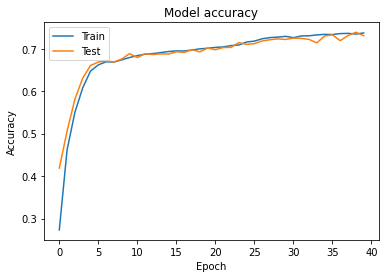

In [53]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#Prediction

Predictions are made on the test set. The mean-squared error (MSE) is calculated between the test set and their predictions. If the MSE is high, it's a potential irregularity that might suggest fraud. It's not perfect, there will be false positives and false negatives.



In [54]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})

In [55]:
error_df.head()


,reconstruction_error,true_class
8225,0.327150,0.0
10794,0.872783,0.0
9163,0.316748,0.0
26591,0.158622,0.0
6631,0.407375,0.0


#Plot Reconstruction Error

The reconstruction error for each sample is plotted long with a color code indicating known fraud. Only 6000 samples are plotted, but the index is randomly sampled from the original set, so the X-axis shows almost the full range of indices.



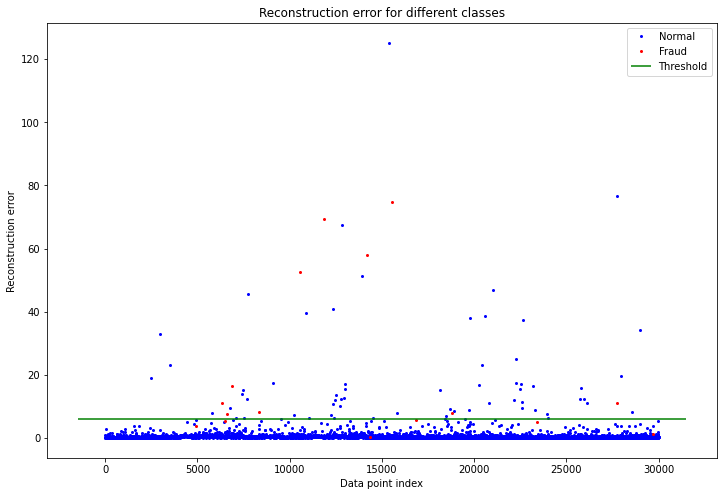

In [56]:
threshold = 6.0

groups = error_df.groupby('true_class')
fig, ax = plt.subplots(figsize=(12, 8))

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=2.0, linestyle='',
            label = "Fraud" if name == 1 else "Normal",
            color = "red" if name == 1 else "blue")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="green", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

#above the green line (i.e threshold line) would be considered as fraud 


#Analysis

Given the known fraud transactions, we can determine the number of true/false positives and negatives. Ideally, there should be no false positives and false negatives, but this is an imperfect model. Let's see how well it does.



In [57]:
normal = error_df[error_df.true_class == 0]
fraud = error_df[error_df.true_class == 1]

print('Normal transactions: %d, fraud transactions: %d' % (len(normal), len(fraud)))

Normal transactions: 5984, fraud transactions: 16


In [58]:
true_positives = len(fraud[fraud.reconstruction_error >= threshold])
false_positives = len(normal[normal.reconstruction_error >= threshold])

true_negatives = len(normal[normal.reconstruction_error < threshold])
false_negatives = len(fraud[fraud.reconstruction_error < threshold])

print('True positives: %d, true negatives: %d' % (true_positives, true_negatives))
print('False positives: %d, false negatives: %d' % (false_positives, false_negatives))

True positives: 10, true negatives: 5921
False positives: 63, false negatives: 6


#Confusion Matrix

The confusion matrix below shows the number of true/false positive/negatives. It's not perfect, but not too bad either.



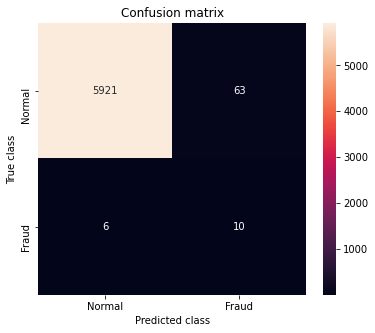

In [59]:
labels = ["Normal", "Fraud"]

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()